In [1]:
from DoWnGAN.prep_gan import (
    load_data,
    mask_and_standardize,
    get_eofs_and_project,
    dt_index,
    find_nearest_index,
    to_utc,
    filter_times
)

import matplotlib.pyplot as plt
import numpy as np

from pkg_resources import resource_filename
import torch
import sys
import mlflow
from sklearn.metrics import mean_squared_error

import xarray as xr

sys.path.insert(0, resource_filename("DoWnGAN", '/'))

In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [3]:
fine_paths = {
    "U": resource_filename("DoWnGAN", "data/wrf/U10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_U10*.nc"),
    "V": resource_filename("DoWnGAN", "data/wrf/V10_regrid_16/regrid_16_6hrly_wrf2d_d01_ctrl_V10*.nc")
}

coarse_paths = {
    "UV": resource_filename("DoWnGAN", "./data/interim_2000-10-01_to_2013-09-30.nc")
}

data = load_data(fine_paths, coarse_paths)

coarse_u10 = data["coarse"].u10.loc["2000-01-01":"2015-05-30"]#.chunk({"time": 250})
coarse_v10 = data["coarse"].v10.loc["2000-01-01":"2015-05-30"]#.chunk({"time": 250})

# Extract times in datetime format
times = dt_index(data["fine_u"].Times)

# Apply filter to times for months you'd like
time_mask = filter_times(times, mask_months=False, test_fraction=0.1)
time_mask[0] = False

fine, coarse = mask_and_standardize(
    time_mask,
    data["fine_u"],
    data["fine_v"],
    coarse_u10,
    coarse_v10,
    8
)


# statmask = ~time_mask
# statmask[0] = False

# mean = fine_t[statmask, ...].mean(dim=0)
# std = fine_t[statmask, ...].std(dim=0)

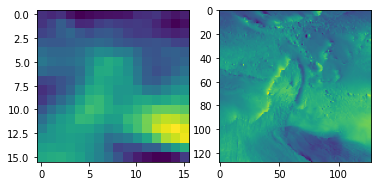

In [4]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse[18, 0, ...])
ax[1].imshow(fine[18, 0, ...])

In [5]:
fine_t = torch.from_numpy(np.array(fine))#.double()
coarse_t = torch.from_numpy(np.array(coarse))#.double()

In [6]:
coarse_wrf = torch.from_numpy(xr.DataArray(fine_t).coarsen(dim_2=8).mean().coarsen(dim_3=8).mean().values)

In [7]:
coarse_wrf.size()

torch.Size([10734, 2, 16, 16])

In [8]:
hashed = "b862005216004409b9e1adb84bfb4a10"
logged_model = f'file:///home/nannau/msc/DoWnGAN/mlruns/1/{hashed}/artifacts/Generator'

G = mlflow.pytorch.load_model(logged_model).to("cpu")
state_dict = mlflow.pytorch.load_state_dict(logged_model)#state_dict.pth")
G.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
fine_t.size()

torch.Size([10734, 2, 128, 128])

In [10]:
torch.cuda.empty_cache()

In [11]:
mean = fine_t.mean(dim=0)
std = fine_t.std(dim=0)

In [12]:
rand_sample = np.random.choice(fine_t.size(0), 2500)

fine_t_og = fine_t[rand_sample, ...]*std + mean
fake_t = G(coarse_t[rand_sample, ...].to("cpu").float())*std + mean

fine_t_og = torch.hypot(fine_t_og[:, 0, ...], fine_t_og[:, 1, ...])
fake_t = torch.hypot(fine_t[:, 0, ...], fine_t[:, 1, ...])
coarse_era = torch.hypot(coarse_t[:, 0, ...], coarse_t[:, 1, ...])
coarse_wrf = torch.hypot(coarse_wrf[:, 0, ...], coarse_wrf[:, 1, ...])

MSE 0.09432m/s


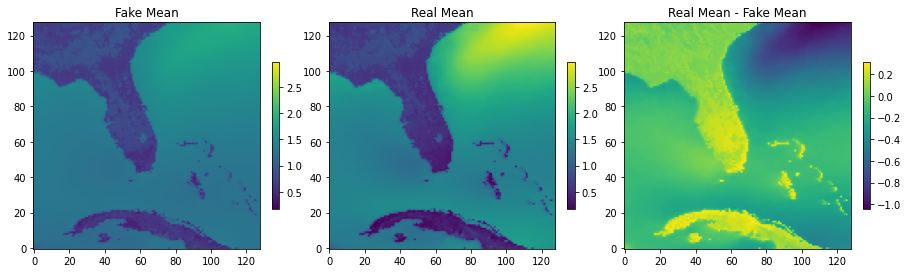

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = fake_t.mean(dim=0).detach().numpy()
B = fine_t_og.mean(dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Fake Mean")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("Real Mean")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Real Mean - Fake Mean")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.01969m/s


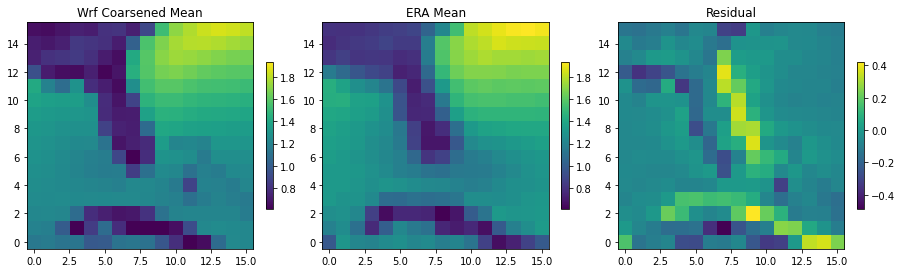

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = coarse_wrf.mean(dim=0).detach().numpy()
B = coarse_era.mean(dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Wrf Coarsened Mean")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("ERA Mean")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.02699m/s


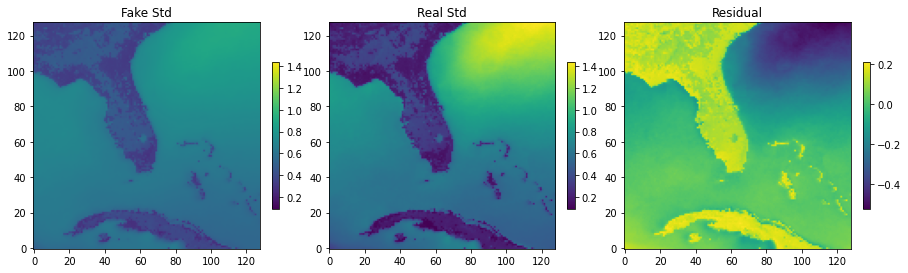

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = fake_t.std(dim=0).detach().numpy()
B = fine_t_og.std(dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower",  vmin=B.min(), vmax=B.max())
ax[0].set_title("Fake Std")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("Real Std")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.00466m/s


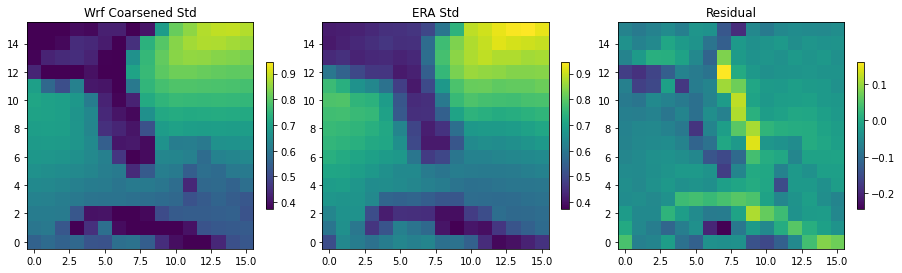

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = coarse_wrf.std(dim=0).detach().numpy()
B = coarse_era.std(dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Wrf Coarsened Std")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("ERA Std")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.04551m/s


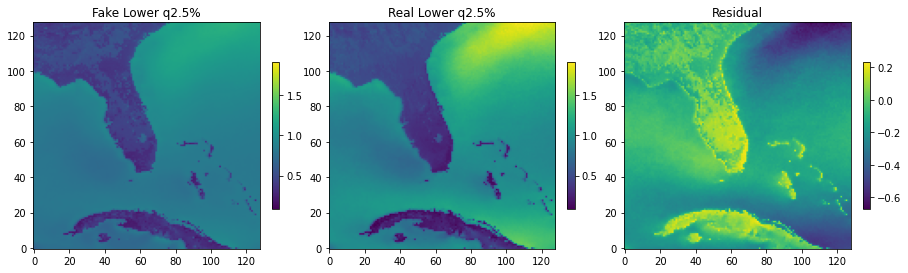

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = torch.quantile(fake_t, q=0.25, dim=0).detach().numpy()
B = torch.quantile(fine_t_og, q=0.25, dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Fake Lower q2.5%")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("Real Lower q2.5%")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.01101m/s


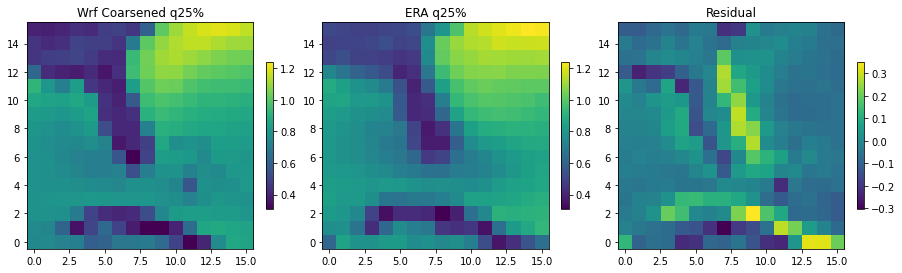

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = torch.quantile(coarse_wrf, q=0.25, dim=0).detach().numpy()
B = torch.quantile(coarse_era, q=0.25, dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Wrf Coarsened q25%")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("ERA q25%")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.32615m/s


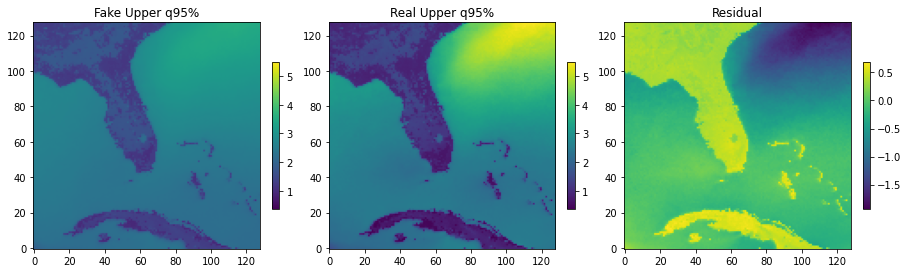

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = torch.quantile(fake_t, q=0.95, dim=0).detach().numpy()
B = torch.quantile(fine_t_og, q=0.95, dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Fake Upper q95%")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("Real Upper q95%")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.07163m/s


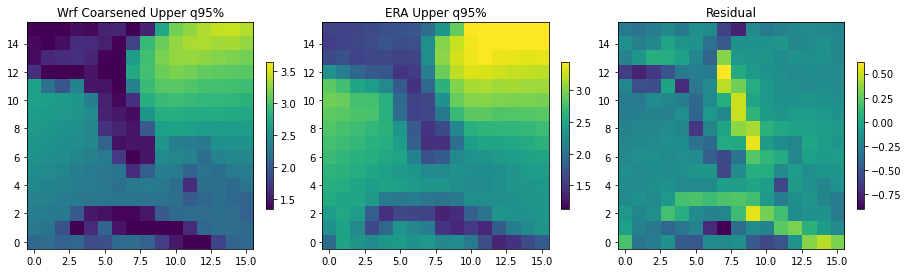

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = torch.quantile(coarse_wrf, q=0.95, dim=0).detach().numpy()
B = torch.quantile(coarse_era, q=0.95, dim=0).detach().numpy()
col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Wrf Coarsened Upper q95%")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=A.min(), vmax=A.max())
ax[1].set_title("ERA Upper q95%")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.05899m/s


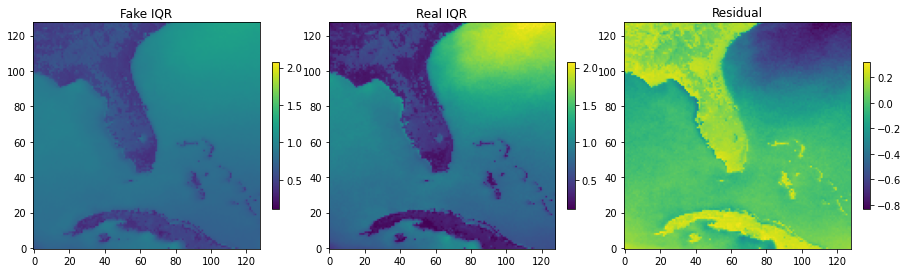

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = torch.quantile(fake_t, q=0.75, dim=0).detach().numpy() - torch.quantile(fake_t, q=0.25, dim=0).detach().numpy()
B = torch.quantile(fine_t_og, q=0.75, dim=0).detach().numpy() - torch.quantile(fine_t_og, q=0.25, dim=0).detach().numpy()

col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Fake IQR")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("Real IQR")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")

MSE 0.00719m/s


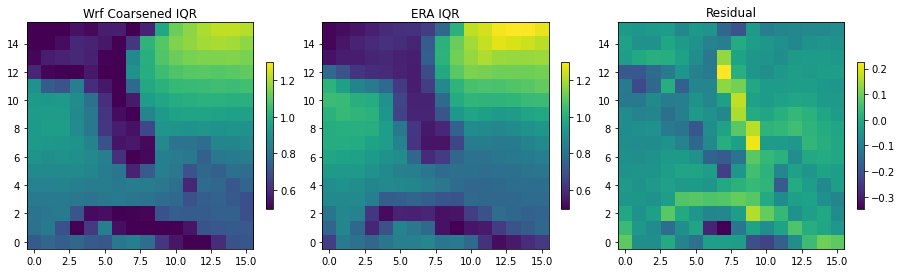

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
A = torch.quantile(coarse_wrf, q=0.75, dim=0).detach().numpy() - torch.quantile(coarse_wrf, q=0.25, dim=0).detach().numpy()
B = torch.quantile(coarse_era, q=0.75, dim=0).detach().numpy() - torch.quantile(coarse_era, q=0.25, dim=0).detach().numpy()

col = ax[0].imshow(A, origin="lower", vmin=B.min(), vmax=B.max())
ax[0].set_title("Wrf Coarsened IQR")
plt.colorbar(col, ax = ax[0], fraction=0.03)
col = ax[1].imshow(B, origin="lower", vmin=B.min(), vmax=B.max())
ax[1].set_title("ERA IQR")
plt.colorbar(col, ax = ax[1], fraction=0.03)
col = ax[2].imshow(A-B, origin="lower")
ax[2].set_title("Residual")
plt.colorbar(col, ax = ax[2], fraction=0.03)

print(f"MSE {mean_squared_error(A, B):.5f}m/s")